In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn  as sb
import warnings
warnings.filterwarnings('ignore')

# Project Introduction
I'll analyze my performance during the matches for this project. I'll try to figure out which agents I play best with and which maps I have the best win rate on. What is the best agent for each map, and finally, a small machine learning model that can predict whether a match will win or lose.

In [2]:
data=pd.read_csv("C:/Users/LITE/Documents/Valorant Analysis/Lite.csv")

In [3]:
data.head()

,Date,Map Name,Match Result,Agent Name,kills,headshots,deaths,assists,damage,damageReceived,plants,defuses,firstBloods,kdRatio,placement,rank
0,2021-11-08T15:49:57.865-05:00,Icebox,defeat,Jett,5,1,14,3,1327,2447,0,0,0,0.357143,9,Silver 1
1,2021-11-07T17:06:44.201-05:00,Fracture,victory,Killjoy,12,5,9,1,2169,1871,9,0,2,1.333333,7,Silver 1
2,2021-11-07T16:28:18.946-05:00,Breeze,defeat,Yoru,3,1,17,2,895,3077,0,0,1,0.176471,9,Silver 1
3,2021-11-07T15:32:01.224-05:00,Haven,victory,Jett,11,6,19,6,2685,3633,1,0,0,0.578947,9,Silver 1
4,2021-11-07T13:40:04.085-05:00,Ascent,defeat,Breach,15,8,20,3,2925,3671,0,0,1,0.750000,4,Silver 1


## Data Cleaning

In this section, I'll split the date column into two columns: datetime and hour.

In [4]:
hour=[]
for i in range(len(data['Date'])):
    hour.append(data['Date'][i].split('T')[1].split('.')[0])
data.insert(1,'hour',hour)    


day=pd.to_datetime(data['Date'])
for i in range(len(day)):
    day[i]=day[i].date()  
data['Date']=day   

In [5]:
data.head()

,Date,hour,Map Name,Match Result,Agent Name,kills,headshots,deaths,assists,damage,damageReceived,plants,defuses,firstBloods,kdRatio,placement,rank
0,2021-11-08,15:49:57,Icebox,defeat,Jett,5,1,14,3,1327,2447,0,0,0,0.357143,9,Silver 1
1,2021-11-07,17:06:44,Fracture,victory,Killjoy,12,5,9,1,2169,1871,9,0,2,1.333333,7,Silver 1
2,2021-11-07,16:28:18,Breeze,defeat,Yoru,3,1,17,2,895,3077,0,0,1,0.176471,9,Silver 1
3,2021-11-07,15:32:01,Haven,victory,Jett,11,6,19,6,2685,3633,1,0,0,0.578947,9,Silver 1
4,2021-11-07,13:40:04,Ascent,defeat,Breach,15,8,20,3,2925,3671,0,0,1,0.750000,4,Silver 1


# Data Visualisation 

#### Top Agent kills 
In this section, I'm looking for the agent with the most kills across all competitive matches.

In [6]:
agent_kills=data[['Agent Name','kills']]
agent_kills=agent_kills.set_index('Agent Name')
agent_kills=agent_kills.groupby(['Agent Name']).sum()
agent_kills=agent_kills.sort_values(by=['kills'],ascending=False)
agent_kills=agent_kills.head()
agent_kills

,kills
Agent Name,
Omen,383
Sage,375
Cypher,327
Jett,188
Phoenix,187


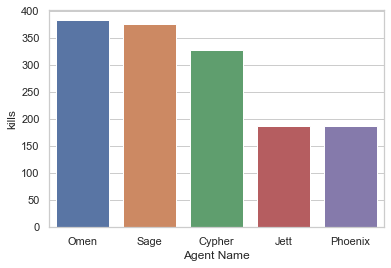

In [7]:
sb.set_theme(style="whitegrid")
ax = sb.barplot(x=agent_kills.index, y=agent_kills['kills'], data=agent_kills)

**Based on this bar chart, we can conclude that Omen (type: controler), Sage (type: sentinelle), and Cypher (type: sentinelle) are the top three agents in terms of kills, followed by two dualists, Jett and Pheonix. But is it enough to say that you're the best agent I've ever played with? Let's dig deeper to see what we can find.**

### Best Agent performance

We are calculating the kd ratio for each agent, which is: the number of kills + the number of deaths / the number of times that agent has been played.

In [8]:
agent_ADR_Count=data[['Agent Name']]
agent_ADR_Count=agent_ADR_Count['Agent Name'].groupby(agent_ADR_Count['Agent Name'].tolist()).size().reset_index().\
    rename(columns={0:'records'})
agent_ADR_Count.rename(columns = {'index': 'Agent Name', 'Agent Name': 'Count'}, inplace = True)
agent_ADR_Count.sort_values('Agent Name')
agent_ADR_Count=agent_ADR_Count.set_index('Agent Name')


In [9]:
agent_ADR=data[['Agent Name','kdRatio']]
agent_ADR=agent_ADR.set_index('Agent Name')
agent_ADR=agent_ADR.groupby(['Agent Name']).sum()
agent_ADR

,kdRatio
Agent Name,
Breach,4.083683
Cypher,23.639299
Jett,10.136827
Killjoy,11.782649
Omen,25.622983
Phoenix,10.666659
Reyna,14.548084
Sage,25.082575
Skye,1.090909


In [10]:
agent_ADR_mean= pd.concat([agent_ADR_Count, agent_ADR], axis=1)
agent_ADR_mean['kdRatio']=agent_ADR_mean['kdRatio']/agent_ADR_mean['Count']
agent_ADR_mean=agent_ADR_mean.drop('Skye')
agent_ADR_mean=agent_ADR_mean.sort_values(by='kdRatio',ascending=False)
agent_ADR_mean=agent_ADR_mean.head()
agent_ADR_mean

,Count,kdRatio
Agent Name,,
Reyna,13,1.119083
Killjoy,14,0.841618
Omen,31,0.826548
Cypher,31,0.762558
Sage,33,0.760078


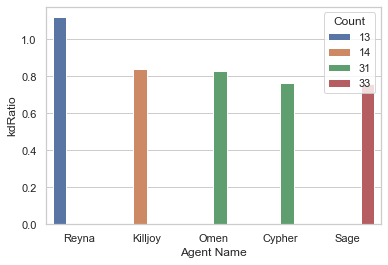

In [11]:
sb.set_theme(style="whitegrid")
ax = sb.barplot(x=agent_ADR_mean.index, y=agent_ADR_mean['kdRatio'],hue="Count", data=agent_ADR_mean)

**As we can see, there are additional results: Reyna, a dualist, has the highest kd ration of 1.119, followed by Killjoy, a sentinelle, with 0.84, and then Omen, Cypher, and Sage. As a result, we have three sentinelle , one controler, and one dualist.**

## Match Results Base Map

In [12]:
Match_Stats=data[['Map Name','Match Result']]
Match_Stats['Match Result'].replace(('victory', 'defeat'), (1, 0), inplace=True)
Match_Stats=Match_Stats.groupby(['Map Name']).sum()
Match_Stats=Match_Stats.sort_values(by='Match Result',ascending=False)
Match_Stats

,Match Result
Map Name,
Ascent,16
Haven,15
Bind,12
Split,9
Fracture,8
Icebox,8
Breeze,7


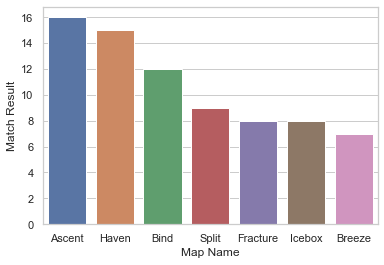

In [13]:
sb.set_theme(style="whitegrid")
ax = sb.barplot(x=Match_Stats.index, y=Match_Stats['Match Result'], data=Match_Stats)

**According to the graph, the most popular maps with a high win rate are Ascent, Haven, and Bind. Actually, as a valorant player, these maps are the first ones that come with the game, so I am very familiar with them. Split, on the other hand, is a cursed map.**

In [14]:
Match_Stats=Match_Stats.head(4)

## Agent and Map 

In this part of analysis, I am going to conclude the performance of the agent that I play and there win rate in the maps

In [15]:
Map_Agent=data[['Map Name','Agent Name']]
Map_Agent=Map_Agent.groupby(['Map Name','Agent Name'])['Agent Name'].count()
Map_Agent=Map_Agent.to_frame()

Map_Agent=Map_Agent.rename(columns={'Agent Name':'N° of Play'})
Map_Agent_KD_Ratio=data[['Map Name','Agent Name','kdRatio']]
Map_Agent_KD_Ratio=Map_Agent_KD_Ratio.groupby(['Map Name','Agent Name'])['kdRatio'].sum()
Map_Agent_KD_Ratio=Map_Agent_KD_Ratio.to_frame()
Map_Agent_KD_Ratio_Normalized= pd.concat([Map_Agent, Map_Agent_KD_Ratio], axis=1)
Map_Agent_KD_Ratio_Normalized['kdRatio']=Map_Agent_KD_Ratio_Normalized['kdRatio']/Map_Agent_KD_Ratio_Normalized['N° of Play']
Map_Agent_KD_Ratio_Normalized

Match_Stats_By_Agent=data[['Map Name','Agent Name','Match Result']]
Match_Stats_By_Agent['Match Result'].replace(('victory', 'defeat'), (1, 0), inplace=True)
Match_Stats_By_Agent=Match_Stats_By_Agent.groupby(['Map Name','Agent Name'])['Match Result'].sum()
Match_Stats_By_Agent=Match_Stats_By_Agent.to_frame()
Match_Stats_By_Agent

Player_Performance_based_Map_and_Agent= pd.concat([Map_Agent_KD_Ratio_Normalized, Match_Stats_By_Agent], axis=1)
Player_Performance_based_Map_and_Agent

N° of Play   kdRatio  Match Result
Map Name Agent Name                                    
Ascent   Breach               3  0.826389             1
         Cypher               6  0.521119             3
         Jett                 3  0.826087             1
         Killjoy              4  0.644841             3
         Omen                 4  0.648510             0
         Phoenix              5  0.712692             2
         Reyna                3  2.126984             1
         Sage                 9  0.727167             5
Bind     Breach               1  0.571429             0
         Cypher               9  0.953159             4
         Jett                 3  0.829714             1
         Killjoy              1  0.909091             1
         Omen                 3  1.062530             2
         Phoenix              2  0.528708             0
         Reyna                1  0.800000             1
         Sage                 6  0.636338             1
         Sova                 2  0.717105             2
Breeze   Jett                 2  0.500000             2
         Killjoy              1  0.928571             1
         Omen                 5  0.734324             2
         Phoenix              3  0.511586             0
         Sage                 3  0.710395             1
         Sova                 2  0.420956             1
         Yoru                 1  0.176471             0
Fracture Cypher               3  1.079365             1
         Killjoy              1  1.333333             1
         Omen                 8  0.891876             5
         Reyna                1  1.307692             1
Haven    Breach               2  0.516544             0
         Cypher               4  0.745705             3
         Jett                 2  0.422807             1
         Killjoy              1  0.846154             1
         Omen                 7  0.780013             3
         Phoenix              3  0.748718             3
         Reyna                1  0.636364             0
         Sage                 8  0.739096             4
         Sova                 1  0.526316             0
Icebox   Cypher               1  0.636364             0
         Jett                 4  0.580952             1
         Killjoy              6  0.864356             4
         Omen                 4  0.893661             1
         Phoenix              2  0.658750             0
         Sage                 4  1.047078             2
Split    Cypher               8  0.634609             1
         Jett                 1  1.000000             1
         Phoenix              1  0.947368             1
         Reyna                7  0.774725             3
         Sage                 3  0.829261             2
         Skye                 1  1.090909             1

In [16]:
Player_Performance_based_Map_and_Agent.sort_values(by='Match Result',ascending=False)
Player_Performance_based_Map_and_Agent

Best_agent_based_map=pd.DataFrame(columns=['Map Name', 'Agent Name', 'N° of Play','kdRatio','Match Result'])
Best_agent_based_map.reset_index()

data_row={}
for index, row in Player_Performance_based_Map_and_Agent.iterrows():
      if(row['Match Result']>row['N° of Play']/2 and row['N° of Play']>3 ):
        data_row={'Map Name':index[0],'Agent Name':index[1],'N° of Play':row['N° of Play'],'kdRatio':row['kdRatio'],'Match Result':row['Match Result']}
        Best_agent_based_map=Best_agent_based_map.append(data_row,ignore_index=True)
Best_agent_based_map=Best_agent_based_map.sort_values(by='N° of Play',ascending=False)      
Best_agent_based_map

,Map Name,Agent Name,N° of Play,kdRatio,Match Result
1,Ascent,Sage,9.0,0.727167,5.0
2,Fracture,Omen,8.0,0.891876,5.0
4,Icebox,Killjoy,6.0,0.864356,4.0
0,Ascent,Killjoy,4.0,0.644841,3.0
3,Haven,Cypher,4.0,0.745705,3.0


**This table provides all of the information that I require; as we can see, I am a <span style="color:green">sentinelle</span>     type of player who does not play aggressively as a <span style="color:green">dualist</span>. I enjoy playing <span style="color:blue">Ascent, Haven, Fracture, and Icebox</span>  Ascent, Haven, Fracture, and Icebox. My main as a controler is <span style="color:green">omen</span> omen.**

# Machine Learning 

**In this machine learning section, I will use a model called linear regression to predict the kd ratio for the agent and the map. Logistic regression is used to predict win-loss outcomes for the agent and the map.**

In [17]:
data_ML=data

In [18]:
data_ML=data_ML.replace(to_replace=['defeat', 'victory'], value=[0, 1])
data_ML=data_ML.replace(to_replace=['Ascent', 'Haven','Bind','Split','Fracture','Icebox','Breeze'], value=[0, 1,2,3,4,5,6])
data_ML=data_ML.replace(to_replace=['Breach', 'Killjoy','Skye','Reyna','Sage','Omen','Cypher','Jett','Phoenix','Yoru','Sova'], value=[0, 1,2,3,4,5,6,7,8,9,10])


data_ML

,Date,hour,Map Name,Match Result,Agent Name,kills,headshots,deaths,assists,damage,damageReceived,plants,defuses,firstBloods,kdRatio,placement,rank
0,2021-11-08,15:49:57,5,0,7,5,1,14,3,1327,2447,0,0,0,0.357143,9,Silver 1
1,2021-11-07,17:06:44,4,1,1,12,5,9,1,2169,1871,9,0,2,1.333333,7,Silver 1
2,2021-11-07,16:28:18,6,0,9,3,1,17,2,895,3077,0,0,1,0.176471,9,Silver 1
3,2021-11-07,15:32:01,1,1,7,11,6,19,6,2685,3633,1,0,0,0.578947,9,Silver 1
4,2021-11-07,13:40:04,0,0,0,15,8,20,3,2925,3671,0,0,1,0.750000,4,Silver 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021-07-16,15:05:30,2,1,1,10,5,11,8,2270,2012,2,1,0,0.909091,6,Bronze 3
162,2021-07-16,09:44:52,2,0,5,8,2,14,3,1440,2130,0,0,1,0.571429,8,Bronze 3
163,2021-07-16,07:13:18,3,0,4,14,7,16,3,2907,2687,3,0,1,0.875000,9,Bronze 3
164,2021-07-15,15:02:45,0,1,4,10,4,14,5,1810,2577,8,1,1,0.714286,10,Bronze 3


In [28]:
data_ML=data_ML[['Map Name','Agent Name','kdRatio','Match Result']]
data_ML

,Map Name,Agent Name,kdRatio,Match Result
0,5,7,0.357143,0
1,4,1,1.333333,1
2,6,9,0.176471,0
3,1,7,0.578947,1
4,0,0,0.750000,0
...,...,...,...,...
161,2,1,0.909091,1
162,2,5,0.571429,0
163,3,4,0.875000,0
164,0,4,0.714286,1


In [35]:
X_Result=data_ML[["Map Name","Agent Name"]]
Y_Result=data_ML[["Match Result"]]
X_kd=data_ML[["Map Name","Agent Name"]]
Y_kd=data_ML[["kdRatio"]]


In [30]:
from sklearn.model_selection import train_test_split
X_train_R,X_test_R,Y_train_R,Y_test_R=train_test_split(X_Result,Y_Result,test_size=0.3,random_state=0)
X_train_KD,X_test_KD,Y_train_KD,Y_test_KD=train_test_split(X_kd,Y_kd,test_size=0.4,random_state=0)

In [37]:
from sklearn.linear_model import LogisticRegression, LinearRegression
model_R=LogisticRegression()
model_R.fit(X_train_R,Y_train_R)
model_KD=LinearRegression()
model_KD.fit(X_train_KD,Y_train_KD)

LinearRegression()

In [42]:
y_pred_R=model_R.predict(X_test_R)
y_pred_KD=model_KD.predict(X_test_KD)

**Finally, those models could not provide a good prediction because there are so many features that should be implemented in the ML input, such as ping<span style="color:blue">(latency is the technically more correct term) means the time it takes for a small data set to be transmitted from your device to a server on the Internet and back to your device again.) </span>  packet loss, computer configuration, team mmr... those features will provide a good prediction with high accuracy.**

In [ ]:
Data_for_report=data
Data_for_report=Data_for_report.replace(to_replace=['defeat', 'victory'], value=[0, 1])
Data_for_report.to_csv('Valorant Lite Performance.csv')
Best_agent_based_map.to_csv('Best_agent_based_map.csv')